# Sequence Classification: Many to One

The goal is to classify sequences. Elements and targets are represented locally (input vectors with only one non-zero bit). The sequence starts with an $B$, ends with an $E$ (the "trigger symbol"), and otherwise consists of randomly chosen symbols from the set $\{a, b, c, d\}$ except for two elements at positions $t_1$ and $t_2$ that are either $X$ or $Y$.

For the DifficultyLevel.HARD case, the sequence length is randomly chosen between $100$ and $110$, $t_1$ is randomly chosen between $10$ and $20$, and $t_2$ is randomly chosen between $50$ and $60$. There are $4$ sequence classes: $Q, R, S, U$, which depend on the temporal order of $X$ and $Y$.

The rules are:
- $X, X$ --> $Q$,
- $X, Y$ --> $R$,
- $Y, X$ --> $S$,
- $Y, Y$ --> $U$.

In [1]:
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [2]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32
)

In [3]:
example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.') 
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}')
print(f'The first element in the batch of sequences is: \n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}')
print(f'The first element in the batch of class labels is : \n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8)
The first element in the batch of sequences is: 
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4)
The first element in the batch of class labels is : 
 [1. 0. 0. 0.]


In [4]:
example_batch[0][0].shape

(9, 8)

In [5]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is : {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is : Q


In [6]:
example_batch[0][0], example_generator.decode_x(example_batch[0][0])

(array([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32),
 'BbXcXcbE')

### Defining the Model

In [7]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, nonlinearity='relu', batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y, _ = self.rnn(x)
        y = self.linear(y)
        return y
        
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        y, _ = self.lstm(x)
        y = self.linear(y)
        return y
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            
            h = torch.cat(h_list)
            c = torch.cat(c_list)
            
        return h, c

### Define the training loop

In [8]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode
    model.train()
    
    # Store the number of sequences that were classified correctly
    num_correct = 0
    
    # Iterate over every batch of sequences
    for batch_idx in range(len(train_data_gen)):
        # Request a batch of seqs and class labels, convert them into tensors of the correct type
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        
        # Perform the forward pass of the model
        output = model(data)
        
        # Pick only the output corresponding to last sequence element
        output = output[:, -1, :]
        
        target = target.argmax(dim=1)
        loss = criterion(output, target)
        
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
    
    return num_correct, loss.item()

### Define the test loop

In [9]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Store the number of sequences that were classified correctly
    num_correct = 0
    
    with torch.no_grad():
        # Iterate over every batch of sequences
        for batch_idx in range(len(test_data_gen)):
            # Request a batch of seqs and class labels, convert them into tensors of the correct type
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            # Perform the forward pass of the model
            output = model(data)

            # Pick only the output corresponding to last sequence element
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()
            
    return num_correct, loss.item()
    

### Putting it All Together

In [10]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [11]:
set_default()

In [12]:
import time
import numpy as np

def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}
    elapsed_times = []
    
    for epoch in range(max_epochs):
        start_t = time.time()
        
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)
        
        elapsed_t = time.time() - start_t
        elapsed_times.append(elapsed_t)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")
            
    print(f'Total training time: {np.sum(elapsed_times):.3f} seconds')
    
    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

### Simple RNN: 10 epochs

In [13]:
# Setup the training and test data generators
difficulty = QRSU.DifficultyLevel.EASY
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Training config
criterion = nn.CrossEntropyLoss()
max_epochs = 20

In [14]:
# Define model and optimizer
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model_rnn = SimpleRNN(input_size, hidden_size, output_size)

optimizer = torch.optim.RMSprop(model_rnn.parameters(), lr=1e-3)

[Epoch 1/20] loss: 1.4213, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 2/20] loss: 1.3603, acc: 30.75% - test_loss: 1.3846, test_acc: 37.50%
[Epoch 3/20] loss: 1.3673, acc: 40.22% - test_loss: 1.3910, test_acc: 40.12%
[Epoch 4/20] loss: 1.3636, acc: 39.82% - test_loss: 1.3435, test_acc: 43.85%
[Epoch 5/20] loss: 1.2752, acc: 44.35% - test_loss: 1.3282, test_acc: 36.59%
[Epoch 6/20] loss: 1.2631, acc: 40.22% - test_loss: 1.2412, test_acc: 41.03%
[Epoch 7/20] loss: 1.2340, acc: 44.35% - test_loss: 1.2670, test_acc: 47.58%
[Epoch 8/20] loss: 1.1193, acc: 50.40% - test_loss: 1.2446, test_acc: 48.69%
[Epoch 9/20] loss: 1.2194, acc: 48.89% - test_loss: 1.1098, test_acc: 50.81%
[Epoch 10/20] loss: 1.0805, acc: 48.69% - test_loss: 1.0649, test_acc: 52.72%
[Epoch 11/20] loss: 1.0800, acc: 56.96% - test_loss: 1.0458, test_acc: 54.54%
[Epoch 12/20] loss: 0.9235, acc: 57.36% - test_loss: 1.0783, test_acc: 58.97%
[Epoch 13/20] loss: 0.9903, acc: 61.69% - test_loss: 0.8852, test_acc: 59

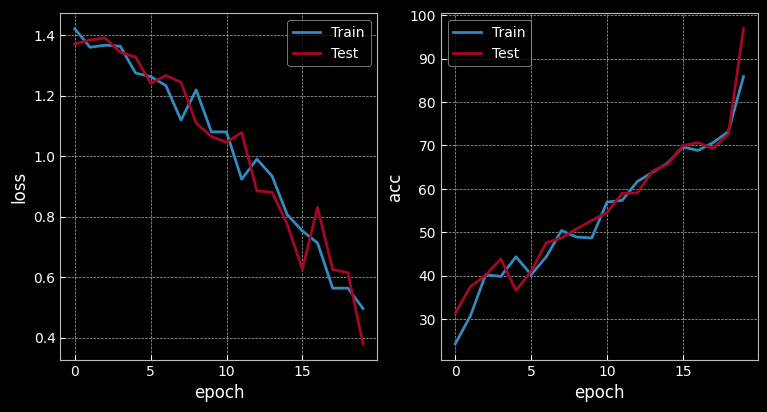

In [15]:
# Train RNN
model_rnn = train_and_test(model_rnn, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

### Simple LSTM: 10 Epochs

In [16]:
# Define model and optimizer
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model_lstm = SimpleLSTM(input_size, hidden_size, output_size)

optimizer = torch.optim.RMSprop(model_lstm.parameters(), lr=1e-3)

[Epoch 1/20] loss: 1.4138, acc: 25.50% - test_loss: 1.4099, test_acc: 34.38%
[Epoch 2/20] loss: 1.3788, acc: 34.88% - test_loss: 1.3406, test_acc: 41.33%
[Epoch 3/20] loss: 1.2944, acc: 43.75% - test_loss: 1.3228, test_acc: 43.75%
[Epoch 4/20] loss: 1.2703, acc: 47.58% - test_loss: 1.2293, test_acc: 49.70%
[Epoch 5/20] loss: 1.1549, acc: 56.85% - test_loss: 1.1849, test_acc: 72.98%
[Epoch 6/20] loss: 1.1281, acc: 74.70% - test_loss: 1.1370, test_acc: 70.36%
[Epoch 7/20] loss: 1.0849, acc: 73.99% - test_loss: 1.0644, test_acc: 68.85%
[Epoch 8/20] loss: 1.0093, acc: 79.03% - test_loss: 1.1041, test_acc: 84.78%
[Epoch 9/20] loss: 0.9019, acc: 86.39% - test_loss: 0.9769, test_acc: 92.44%
[Epoch 10/20] loss: 0.8381, acc: 94.46% - test_loss: 0.8283, test_acc: 95.77%
[Epoch 11/20] loss: 0.7357, acc: 97.88% - test_loss: 0.7189, test_acc: 99.40%
[Epoch 12/20] loss: 0.6685, acc: 99.80% - test_loss: 0.6966, test_acc: 99.90%
[Epoch 13/20] loss: 0.6587, acc: 99.80% - test_loss: 0.6456, test_acc: 10

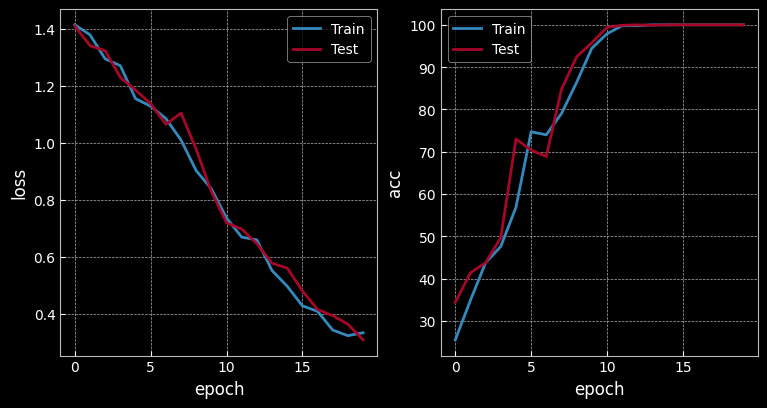

In [17]:
# Train LSTM
model_lstm = train_and_test(model_lstm, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

### Model Evaluation

In [18]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [19]:
evaluate_model(model_rnn, difficulty)

The accuracy of the model is measured to be 97.48%.

Q: 258 / 258 correct
R: 230 / 249 correct
S: 226 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BdYdXbbE -> S was labelled S
BbXcXbcE -> Q was labelled Q
BdYdXbbE -> S was labelled S
BYdcaYbE -> U was labelled U
BcYdYdaE -> U was labelled U
BYbdYabE -> U was labelled U
BcYacYbE -> U was labelled U
BdYdXbbE -> S was labelled S
BbXaXdE -> Q was labelled Q
BdYdXbbE -> S was labelled S

There were no misclassified sequences.


In [20]:
evaluate_model(model_lstm, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 258 / 258 correct
R: 249 / 249 correct
S: 232 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BcYacYbE -> U was labelled U
BdYdXbbE -> S was labelled S
BdYcbXE -> S was labelled S
BbXaXdE -> Q was labelled Q
BdYcbXE -> S was labelled S
BcYdYdaE -> U was labelled U
BdYdXbbE -> S was labelled S
BYdcaYbE -> U was labelled U
BXacbYdE -> R was labelled R
BYdcaYbE -> U was labelled U

There were no misclassified sequences.


In [25]:
evaluate_model(model_gru, difficulty)

NameError: name 'model_gru' is not defined

### Visualize LSTM

In [21]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_lstm.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model_lstm.get_states_across_time(X)

In [22]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [23]:
plot_state(X.cpu(), C_t, b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [24]:
plot_state(X.cpu(), H_t, b=9, decoder=test_data_gen.decode_x)